In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob as glob
import datetime as dt
import os
import zipfile
from matplotlib.pylab import rcParams
sns.set()
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                    
from tqdm import tqdm_notebook
import warnings                                  
warnings.filterwarnings('ignore')
%matplotlib inline
rcParams['figure.figsize'] = 10, 6

In [2]:
os.environ["MODIN_ENGINE"] = "dask"

In [3]:
import time
#import modin.pandas as pd_moding

In [4]:
files = glob.glob(r"D:\Desktop\DataNequi\*.parquet")

In [6]:
files=files[:4]

In [7]:
df = pd.DataFrame()
for f in files:
    appenddata = pd.read_parquet(f)
    appenddata['filename'] = os.path.basename(f)
    appenddata.columns = map(str.lower, appenddata.columns)
    df = df.append(appenddata,ignore_index=True)
df.drop(df.filter(like='unname').columns,axis=1,inplace=True)

In [6]:
def date_format(x):
    try:
        return dt.datetime.strptime(x,"%d/%m/%Y %H:%M:%S")
    except:
        return np.nan

In [9]:
df['transaction_date']=pd.to_datetime(df['transaction_date'],format="%Y-%m-%d %H:%M:%S")

In [10]:
rs=df.groupby(['merchant_id','subsidiary','account_number','user_id',pd.Grouper(key='transaction_date',freq='24h')]).agg({'_id':'nunique'}).reset_index()
rs.rename(columns={'_id':'cantidad'},inplace=True)

In [27]:
rs=rs[rs['cantidad']!=1]

In [28]:
rs1=rs.groupby(['transaction_date']).agg({'cantidad':sum})

In [29]:
rs1=rs1.reset_index()

In [30]:
rs1['transaction_date'].max()

Timestamp('2021-11-30 00:00:00')

In [31]:
rs1['transaction_date'].min()

Timestamp('2021-01-01 00:00:00')

In [32]:
#recaudo_2020=recaudo_2020[(recaudo_2020['FECHA_PAGO']>'2014-12-31')&(recaudo_2020['FECHA_PAGO']<'2020-01-01')]
#df[(df['date'] > '2013-01-01') & (df['date'] < '2013-02-01')]

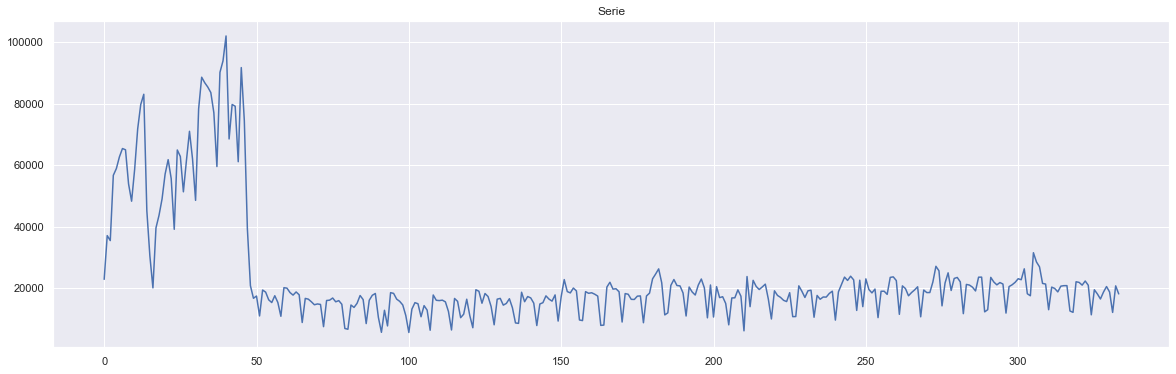

In [33]:
plt.figure(figsize=(20, 6))
plt.plot(rs1.cantidad)
plt.title('Serie')
plt.grid(True)
plt.show()

In [35]:
rs1.set_index('transaction_date',inplace=True)

In [37]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(rs1, 30) # prediction for the last observed day (past 4 hours)

19587.5

In [38]:
from sklearn.metrics import mean_absolute_error

In [39]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, 
                      plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "black", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

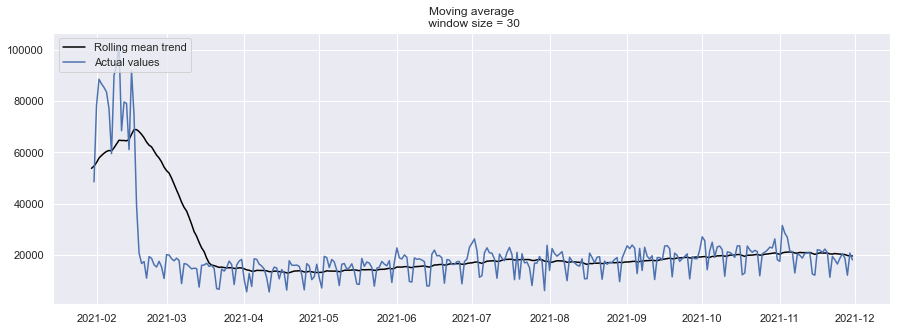

In [40]:
 plotMovingAverage(rs1, 30)

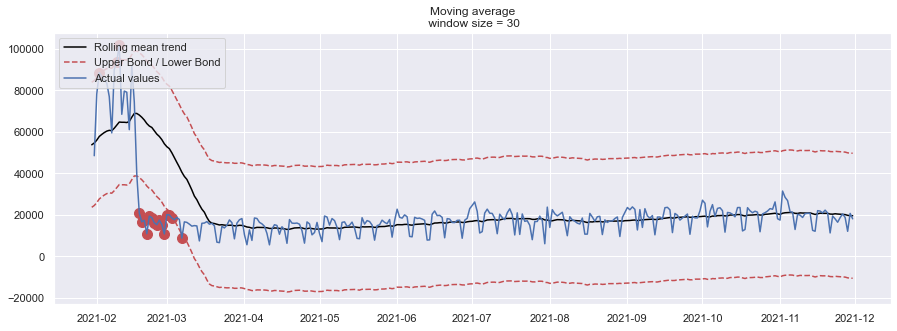

In [41]:
plotMovingAverage(rs1, 30, plot_intervals=True, plot_anomalies=True)

In [42]:
######## quiero mirar la estacionarionaridad d ela serie

In [43]:
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.api as sm

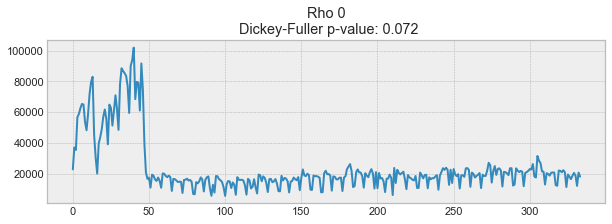

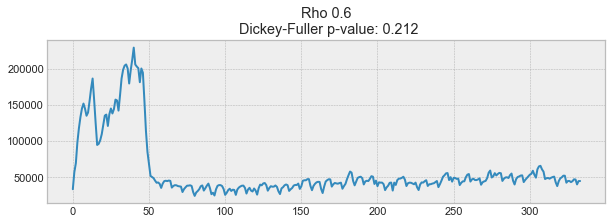

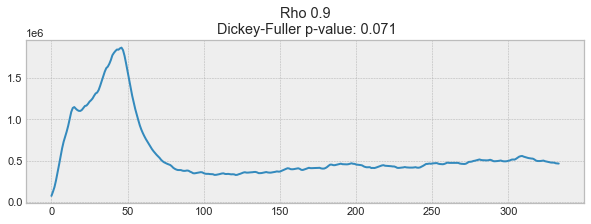

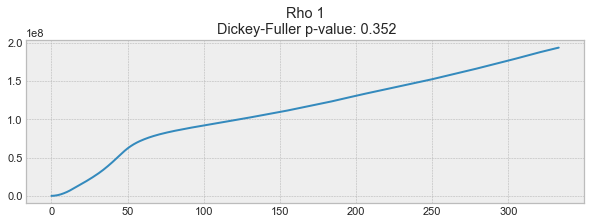

In [44]:
def plotProcess(x,rho=0):
    w = x 
    for t in range(len(x)):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3))) 
x = rs1.copy()

for rho in [0, 0.6, 0.9, 1]:
    plotProcess(x.values,rho=rho)

In [45]:
X = x.values
result = sm.tsa.stattools.adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
     print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.858759
p-value: 0.351704
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


In [46]:
import statsmodels.tsa.api as smt

In [47]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

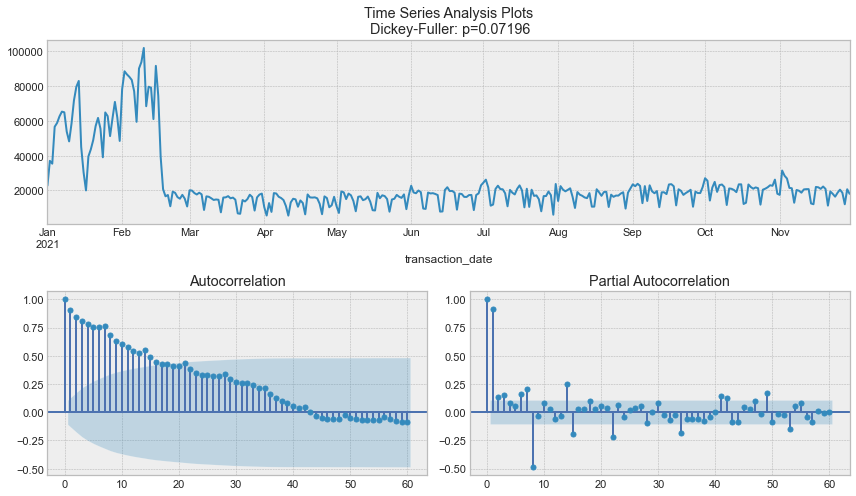

In [48]:
tsplot(rs1.cantidad, lags=60)

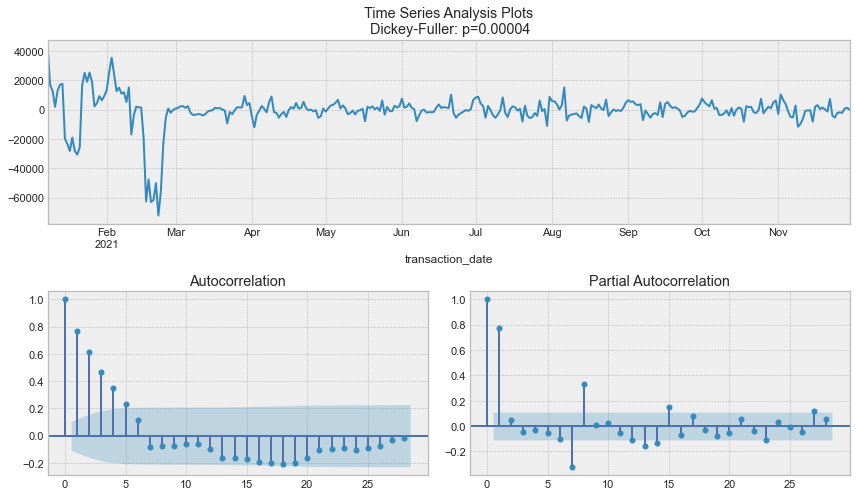

In [50]:
ads_diff = (rs1.cantidad - rs1.cantidad.shift(7))
tsplot(ads_diff[7:], lags=28)

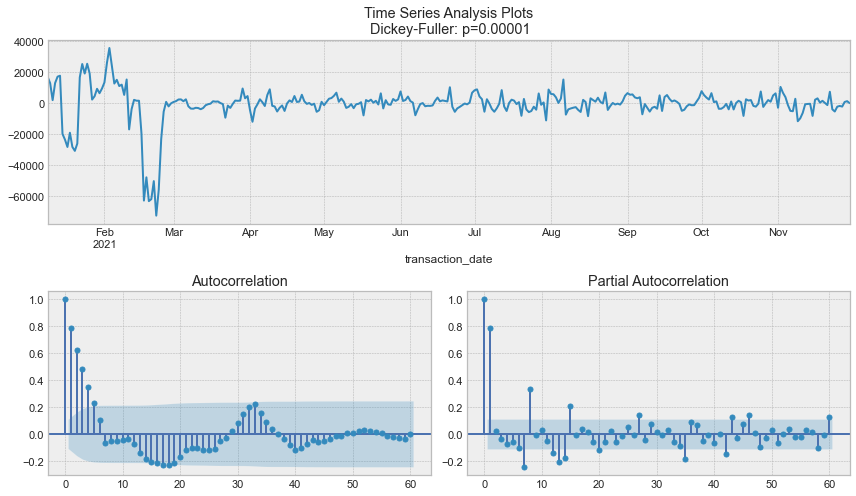

In [51]:
tsplot(ads_diff[7+1:], lags=60)

In [52]:
from itertools import product                    # some useful functions

In [53]:
# setting initial values and some bounds for them
ps = range(1, 7)
d=1 
qs = range(1, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 7
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

96

In [57]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(rs1.cantidad, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [58]:
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/96 [00:00<?, ?it/s]

In [59]:
result_table.head()

,parameters,aic
0,"(5, 3, 1, 1)",6610.066941
1,"(4, 3, 1, 1)",6610.544319
2,"(1, 2, 1, 1)",6610.846559
3,"(1, 1, 1, 1)",6611.249124
4,"(6, 3, 1, 1)",6611.932595


In [60]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(rs1.cantidad, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            cantidad   No. Observations:                  334
Model:             SARIMAX(5, 1, 3)x(1, 1, [1], 7)   Log Likelihood               -3294.033
Date:                             Wed, 15 Jun 2022   AIC                           6610.067
Time:                                     01:32:42   BIC                           6651.723
Sample:                                 01-01-2021   HQIC                          6626.690
                                      - 11-30-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2682      0.182     -1.477      0.140      -0.624       0.088
ar.L2         -0.4197      

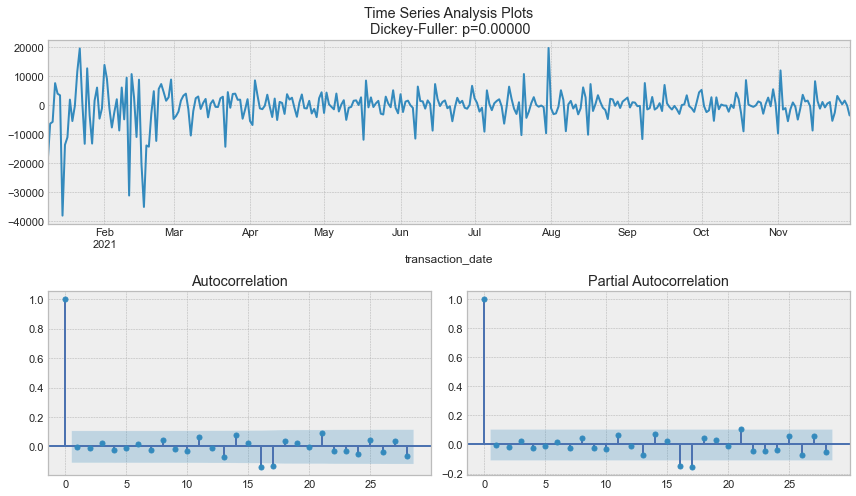

In [61]:
tsplot(best_model.resid[7+1:], lags=28)

In [62]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    #error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    error = mean_absolute_error(data['actual'][s+d:], data['arima_model'][s+d:])
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

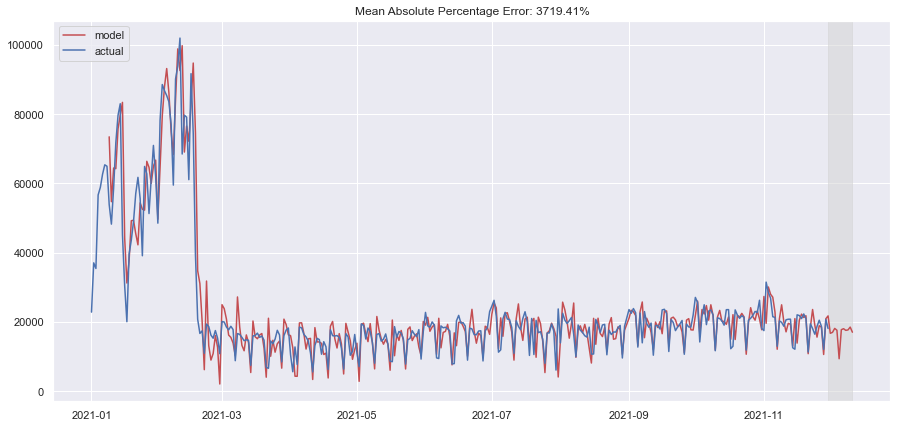

In [63]:
plotSARIMA(rs1, best_model, 10)

In [64]:
n_steps=15 ## cantidad de días a predecir

In [66]:
pronos=best_model.get_prediction(start=-10, end = rs1.shape[0]+n_steps)

In [67]:
media_pronosticada=pronos.predicted_mean

In [71]:
ypred = best_model.predict(start = rs1.shape[0]-15, end = rs1.shape[0]+n_steps)
print(ypred)

2021-11-16    13865.671701
2021-11-17    20475.424263
2021-11-18    22229.228543
2021-11-19    21267.130310
2021-11-20    21761.748971
2021-11-21    10805.856077
2021-11-22    18447.047111
2021-11-23    23570.154963
2021-11-24    19085.441228
2021-11-25    15592.098441
2021-11-26    18886.210650
2021-11-27    18488.534102
2021-11-28    10580.781788
2021-11-29    20912.117327
2021-11-30    21724.073891
2021-12-01    16694.427139
2021-12-02    16970.115230
2021-12-03    18106.551262
2021-12-04    17588.209319
2021-12-05     9347.980477
2021-12-06    17747.838944
2021-12-07    18026.074108
2021-12-08    17551.468673
2021-12-09    17668.654830
2021-12-10    18488.880148
2021-12-11    17011.688475
2021-12-12     8045.880345
2021-12-13    17019.444883
2021-12-14    19065.358555
2021-12-15    18755.007578
Freq: D, Name: predicted_mean, dtype: float64


In [72]:
one_step_forecast = best_model.get_prediction(start=-15)

mean_forecast = one_step_forecast.predicted_mean

confidence_intervals = one_step_forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower cantidad']
upper_limits = confidence_intervals.loc[:,'upper cantidad']
print(mean_forecast)

2021-11-16    13865.671701
2021-11-17    20475.424263
2021-11-18    22229.228543
2021-11-19    21267.130310
2021-11-20    21761.748971
2021-11-21    10805.856077
2021-11-22    18447.047111
2021-11-23    23570.154963
2021-11-24    19085.441228
2021-11-25    15592.098441
2021-11-26    18886.210650
2021-11-27    18488.534102
2021-11-28    10580.781788
2021-11-29    20912.117327
2021-11-30    21724.073891
Freq: D, Name: predicted_mean, dtype: float64


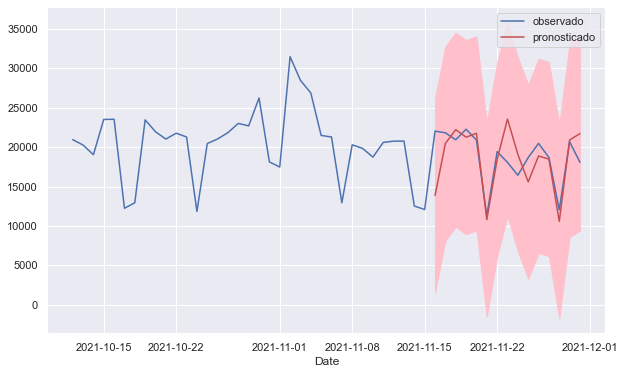

In [73]:
# plot the amazon data
plt.plot(rs1.index[-50:], rs1[-50:], label='observado')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='pronosticado')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('')
plt.legend()
plt.show()

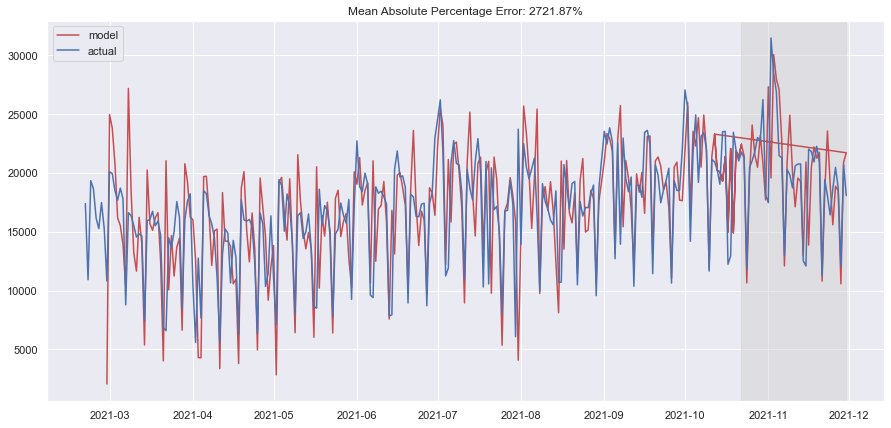

In [74]:
plotSARIMA(rs1[50:], best_model, 10)

In [80]:
# Generar predicciones obtener los intervalos de confianza (upper & lower)
dynamic_forecast = best_model.get_prediction(start=10, dynamic=True)
mean_forecast = dynamic_forecast.predicted_mean
confidence_intervals = dynamic_forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower VALOR_TARIFA']
upper_limits = confidence_intervals.loc[:,'upper VALOR_TARIFA']
print(mean_forecast)

2015-01-12    3.241917e+08
2015-01-13    3.563815e+08
2015-01-14    3.473357e+08
2015-01-15    3.502879e+08
2015-01-16    4.118294e+08
                  ...     
2021-01-14    3.701090e+10
2021-01-15    3.709407e+10
2021-01-16    3.695322e+10
2021-01-17    3.690621e+10
2021-01-18    3.713965e+10
Freq: D, Name: predicted_mean, Length: 2199, dtype: float64


In [85]:
mean_forecast.head(25)

2015-01-12    3.241917e+08
2015-01-13    3.563815e+08
2015-01-14    3.473357e+08
2015-01-15    3.502879e+08
2015-01-16    4.118294e+08
2015-01-17    2.546067e+08
2015-01-18    2.064559e+08
2015-01-19    4.518359e+08
2015-01-20    4.594022e+08
2015-01-21    4.418132e+08
2015-01-22    4.527454e+08
2015-01-23    5.313635e+08
2015-01-24    3.896898e+08
2015-01-25    3.410827e+08
2015-01-26    5.777133e+08
2015-01-27    5.755209e+08
2015-01-28    5.581231e+08
2015-01-29    5.670038e+08
2015-01-30    6.510710e+08
2015-01-31    5.087799e+08
2015-02-01    4.629602e+08
2015-02-02    6.955021e+08
2015-02-03    6.945728e+08
2015-02-04    6.742446e+08
2015-02-05    6.854501e+08
Freq: D, Name: predicted_mean, dtype: float64

## Fin del notebook

In [81]:
### Estudiando 

In [31]:
#rs[rs['DESC_CONCEPTO']=='Pago 25% Centro Atencion']

In [32]:
rs_concepto=rs.groupby(['Año']).agg({'VALOR_TARIFA':sum})
rs_concepto.style.background_gradient(cmap='Oranges',axis = 0).format("${:.0f}")

,VALOR_TARIFA
Año,
2018.0,$107050670891
2019.0,$137193518853
2020.0,$128836095962
2021.0,$2740370392


In [33]:
rs_concepto=rs.groupby(['Año','DESC_CONCEPTO']).agg({'VALOR_TARIFA':sum})
rs_concepto.style.background_gradient(cmap='Oranges',axis = 0).format("${:.0f}")

In [34]:
rs.columns

Index(['FECHA_PAGO', 'DESC_CONCEPTO', 'VALOR_TARIFA', 'DESC_PUNTO_ATENCION',
       'CONSECUTIVO_MOROSOS', 'DESC_TIPOS_COMPARENDOS',
       'NRO_COMPARENDO_O_MOROSO', 'FECHA_RESOLUCION', 'COBRO_COACTIVO',
       'COD_INFRACCION_COMP_MOROSO', 'DESCRIPCION', 'DESCRIPCION_TIPO_PAGO',
       'Año'],
      dtype='object')

In [35]:
rs["Nucleo"] =\
        np.where(rs["NRO_COMPARENDO_O_MOROSO"].str.contains("D",regex = True,na = False),"N2","N1")

In [36]:
rs_concepto=rs.groupby(['Año','Nucleo']).agg({'VALOR_TARIFA':sum})
rs_concepto.style.background_gradient(cmap='Oranges',axis = 0).format("${:.0f}")

In [37]:
rs.columns

Index(['FECHA_PAGO', 'DESC_CONCEPTO', 'VALOR_TARIFA', 'DESC_PUNTO_ATENCION',
       'CONSECUTIVO_MOROSOS', 'DESC_TIPOS_COMPARENDOS',
       'NRO_COMPARENDO_O_MOROSO', 'FECHA_RESOLUCION', 'COBRO_COACTIVO',
       'COD_INFRACCION_COMP_MOROSO', 'DESCRIPCION', 'DESCRIPCION_TIPO_PAGO',
       'Año', 'Nucleo'],
      dtype='object')

In [41]:
PICOYPLACA=rs[rs['COD_INFRACCION_COMP_MOROSO'].str.contains('C14',na=False)]

In [44]:
PICOYPLACA=rs[rs['COD_INFRACCION_COMP_MOROSO']=='C14']

In [46]:
PICOYPLACA_=PICOYPLACA.groupby(['Año','COD_INFRACCION_COMP_MOROSO']).agg({'VALOR_TARIFA':sum})
PICOYPLACA_.style.background_gradient(cmap='Oranges',axis = 0).format("${:.0f}")

,,VALOR_TARIFA
Año,COD_INFRACCION_COMP_MOROSO,
2018.0,C14,$16982422490
2019.0,C14,$22908210295
2020.0,C14,$16639596661
2021.0,C14,$258069903


In [26]:
rs['FECHA_PAGO'].tail()

1387380   2020-07-08 14:40:36
1387381   2020-10-06 19:46:24
1387383   2020-03-02 17:00:06
1387386   2020-11-06 13:29:33
1387388   2020-08-24 07:53:29
Name: FECHA_PAGO, dtype: datetime64[ns]

In [47]:
rs1.columns

Index(['FECHA_PAGO', 'DESC_CONCEPTO', 'VALOR_TARIFA', 'DESC_PUNTO_ATENCION',
       'CONSECUTIVO_MOROSOS', 'DESC_TIPOS_COMPARENDOS',
       'NRO_COMPARENDO_O_MOROSO', 'FECHA_RESOLUCION', 'COBRO_COACTIVO',
       'COD_INFRACCION_COMP_MOROSO', 'DESCRIPCION'],
      dtype='object')

In [50]:
rs['Day_of_week']=rs['FECHA_PAGO'].dt.day_name()

KeyboardInterrupt: 

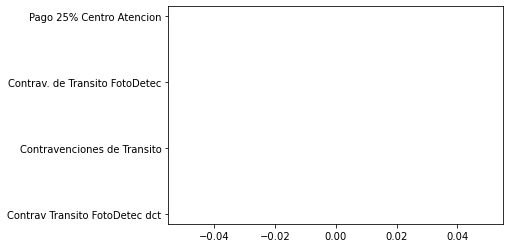

In [52]:
for i in rs['DESC_CONCEPTO']:
    plt.plot(i)

In [ ]:
plt.plot()

In [55]:
contravenciones=rs[rs['DESC_CONCEPTO']=='Contrav Transito FotoDetec dct']

In [60]:
rs_2021=rs[rs['FECHA_PAGO']>'2020-03-01']

In [ ]:
hue=rs_2021[rs_2021["DESC_CONCEPTO"]=='Contrav Transito FotoDetec dct']

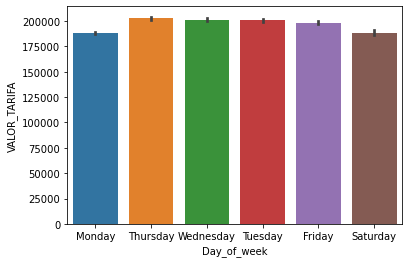

In [63]:
ax = sns.barplot(x="Day_of_week", y="VALOR_TARIFA",data=rs_2021)

In [58]:
sns.barhplot(x='Day_of_week', y='VALOR_TARIFA', data=contravenciones)

AttributeError: module 'seaborn' has no attribute 'barhplot'

In [ ]:
dft1 = rs.copy()
cat_cols = ['Sex', 'Embarked']

dft1[cat_cols]= dft1[cat_cols].astype('category')

In [ ]:
f,ax =plt.subplots(len(rs['DESC_CONCEPTO']),1,figsize=(5,10))
for idx,col in enumerate(rs['DESC_CONCEPTO']):
    sns.countplot(x=col,data=dft1,hue='Survived', ax=ax[idx])

In [54]:
def display_some_results(X_data):
    data = rs[['DESC_CONCEPTO']]
    for camara in range(47): # hay 47 camaras
        t1 = np.arange(0,120)
        prueba_1 = rs['VALOR_TARIFA']
        
        # predict
        t2 = np.arange(10,130) 
        prueba_2 = predict[:,:,camara].reshape(120)
        
        plt.title("Camara: {}".format(registros_historico.columns[camara]))
        plt.plot(t1,prueba_1,label = "True")
        plt.plot(t2,prueba_2,label = "Predict")
        plt.grid(True)
        plt.legend()
        plt.show()
    return print("OK")

In [ ]:
display_some_results(X_data = X_test) 

In [49]:
rs1['Day_of_week']

0             Monday
1             Monday
2            Tuesday
3            Tuesday
4            Tuesday
             ...    
1675371    Wednesday
1675372    Wednesday
1675373    Wednesday
1675374       Monday
1675375       Monday
Name: Day_of_week, Length: 1675376, dtype: object

In [ ]:
import pandas as pd


df = pd.DataFrame({'my_dates':['2015-01-01','2015-01-02','2015-01-03'],'myvals':[1,2,3]})
df['my_dates'] = pd.to_datetime(df['my_dates'])

df['day_of_week'] = df['my_dates'].dt.day_name()

In [27]:
#rs[rs.duplicated()]

In [28]:
recaudo_infrac = pd_moding.read_csv('Z:/Z_Analitica/Recaudo/Recaudo_X_Infractor.csv',sep = ";",
encoding="ISO-8859-1",parse_dates=["FECHA_LIQUIDA","FECHA_COMPARENDO","FECHA_NACIMIENTO","FECHA_NOTIFICACION"],date_parser=lambda x: pd.to_datetime(x,format ="%d/%m/%Y %H:%M:%S",errors = "coerce"))._to_pandas()

In [29]:
recaudo_infrac.drop_duplicates('NRO_COMPARENDO',inplace=True)

In [30]:
rs.duplicated().sum()

146001

In [31]:
aldeamos = pd.DataFrame()
for f in glob.glob("D:/Desktop/ITS_/Aldeamo/Alde/*.txt"):
    df = pd.read_csv(f,sep=';', encoding='ISO-8859-1',
                     dtype={"Etiqueta de correlacion":"str","Fecha Clic URL 1":'str'},
                     parse_dates=['Fecha de Carga (America/Bogota)'],
                     usecols=['Id Envio', 'Telefono celular', 'Mensaje',
                             'Fecha de Carga (America/Bogota)',
                            'Fecha y hora procesado (America/Bogota)', 'Estado del envio',
                            'Referencia', 'Usuario', 'ID de transaccion', 'Etiqueta de correlacion',
                            'Operador', 'Grupo', 'Tipo Mensaje', 'Total de mensajes', 'URL 1',
                            'Total Clics URL 1', 'Fecha Clic URL 1'],
                     date_parser=lambda x: pd.to_datetime(x,format ="%d/%m/%Y %H:%M:%S",errors = "coerce"))
    aldeamos = aldeamos.append(df,ignore_index=True)

In [32]:
rs["Se_contacto"] =\
        np.where(rs["NRO_COMPARENDO_O_MOROSO"].isin(aldeamos["Etiqueta de correlacion"]),"Sí","No")
rs.groupby('Se_contacto').agg({'NRO_COMPARENDO_O_MOROSO':['nunique','count']})

NRO_COMPARENDO_O_MOROSO        
                            nunique   count
Se_contacto                                
No                           963574  984375
Sí                            63014   63145

In [33]:
recaudo_concepto=pd.merge(rs,recaudo_infrac[['NRO_COMPARENDO','ID_USUARIO','TIPO_COMPARENDO','DESC_MARCA','CLASE','SECRETARIA','FECHA_NACIMIENTO','SEXO','RETENCION','TIPO_PERSONA']],left_on='NRO_COMPARENDO_O_MOROSO',right_on='NRO_COMPARENDO',how='left')

In [34]:
recaudo_infrac.columns

Index(['NRO_RECIBO', 'NRO_TRAMITE', 'FECHA_LIQUIDA', 'ID_USUARIO',
       'NRO_COMPARENDO', 'TIPO_COMPARENDO', 'ID_FUENTE', 'ESTADO_COMPARENDO',
       'ESTADO_MOROSO', 'FECHA_COMPARENDO', 'COBRO_COACTIVO', 'DIRECCION',
       'VALOR_COMPARENDO', 'VALOR_PAGADO', 'NUMERO_PLACA', 'CLASE', 'SERVICIO',
       'DESC_LINEA', 'MODELO', 'DESC_MARCA', 'COD_INFRACCION',
       'DESC_INFRACCION', 'DESCRIPCION', 'FECHA_NOTIFICACION', 'SECRETARIA',
       'FECHA_NACIMIENTO', 'SEXO', 'RETENCION', 'TIPO_PERSONA',
       'TIPO_SANCION'],
      dtype='object')

In [35]:
recaudo_concepto.columns

Index(['FECHA_PAGO', 'DESC_CONCEPTO', 'VALOR_TARIFA', 'DESC_PUNTO_ATENCION',
       'CONSECUTIVO_MOROSOS', 'DESC_TIPOS_COMPARENDOS',
       'NRO_COMPARENDO_O_MOROSO', 'FECHA_RESOLUCION', 'COBRO_COACTIVO',
       'COD_INFRACCION_COMP_MOROSO', 'DESCRIPCION', 'DESCRIPCION_TIPO_PAGO',
       'Año', 'Nucleo', 'Se_contacto', 'NRO_COMPARENDO', 'ID_USUARIO',
       'TIPO_COMPARENDO', 'DESC_MARCA', 'CLASE', 'SECRETARIA',
       'FECHA_NACIMIENTO', 'SEXO', 'RETENCION', 'TIPO_PERSONA'],
      dtype='object')

In [36]:
#########################

In [37]:
recaudo_concepto['COD_INFRACCION_COMP_MOROSO']

0                C2
1               C29
2                C2
3               C14
4          902 - C2
             ...   
1960299          B1
1960300          C2
1960301         C14
1960302         C35
1960303          C2
Name: COD_INFRACCION_COMP_MOROSO, Length: 1960304, dtype: object

In [38]:
recaudo_concepto['Edad'] = (dt.datetime.now().year - recaudo_concepto["FECHA_NACIMIENTO"].dt.year)

In [39]:
df = pd_moding.read_csv("Z:/Reportes_General/01_Diario/Imposicion/Informe_Imposicion_diario.txt",sep="\t",encoding="ISO-8859-1",parse_dates=["FECHA_COMPARENDO"],date_parser=lambda x: pd.to_datetime(x,format ="%d/%m/%Y",errors = "coerce"))._to_pandas()


In [40]:
df.shape

(667789, 34)

In [41]:
recaudo_concepto['COD_INFRACCION_COMP_MOROSO']

0                C2
1               C29
2                C2
3               C14
4          902 - C2
             ...   
1960299          B1
1960300          C2
1960301         C14
1960302         C35
1960303          C2
Name: COD_INFRACCION_COMP_MOROSO, Length: 1960304, dtype: object

In [42]:
df.columns

Index(['AÑO_IMPOSICION', 'MES_IMPOSICION', 'FECHA_COMPARENDO',
       'HORA_COMPARENDO', 'NUMERO_PLACA', 'NRO_COMPARENDO', 'TIPO_COMPARENDO',
       'ESTADO_COMPARENDO', 'DIRECCION_COMPARENDO', 'VALOR_DIARIO',
       'VALOR_SMD', 'VALOR_COMPARENDO', 'POLCA', 'REPORTA_FUGA',
       'ESTADO_MOROSOS', 'NUMERO_RES', 'NRO_RESOLUCION', 'DESCRIPCION',
       'DESC_SERVICIO', 'DESC_CLASE', 'DESC_INFRACCION', 'COD_INFRACCION',
       'PLACA_AGENTE', 'NOMBRE_AGENTE', 'NOMBRE_TIPO', 'ID_USUARIO',
       'DESC_DOCUMENTO', 'NOMBRES', 'DIRECCION_USUARIO', 'NOMBRE_CIUDAD_DIR',
       'TIPO_NOTIFICACION', 'FECHA_NOTIFICACION', 'SECRETARIA',
       'FEC_POSIBLE_PRESCRIP'],
      dtype='object')

In [43]:
recaudo_concepto2=pd.merge(recaudo_concepto,df[['NRO_COMPARENDO','DESC_SERVICIO','DESC_CLASE','TIPO_NOTIFICACION','NOMBRE_CIUDAD_DIR']],left_on='NRO_COMPARENDO_O_MOROSO',right_on='NRO_COMPARENDO',how='left')

In [44]:
firmados=pd.read_csv('Z:/Z_Analitica/14_Firmados historico/Firmados_20200101_20201113.csv',sep=',',encoding="ISO-8859-1",date_parser=lambda x: pd.to_datetime(x,format ="%d/%m/%Y",errors = "coerce"),parse_dates=["FECHA DETECCION","FECHA PROCESO"],dtype=str)

In [62]:
firmados.head()

,PUNTO,ALIASCAMARA,NROCOMPARENDO,PLACA,FECHA DETECCION,FECHA PROCESO,CODIGOINFRACCION
0,66,TUGO II,D05001000000025854031,QID544,2019-12-26,2020-01-01,C14
1,52,METROPLUS BELEN,D05001000000025852553,GIY136,2019-12-26,2020-01-02,C35
2,40,EXITO POBLADO,D05001000000025844391,JHR708,2019-12-26,2020-01-02,D4
3,33,LA MOTA,D05001000000025847683,MNP754,2019-12-26,2020-01-02,C14
4,31,ESTACIÓN ESTADIO,D05001000000025848261,FCK514,2019-12-26,2020-01-02,C14


In [65]:
firmados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411845 entries, 0 to 411884
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   PUNTO             411845 non-null  int64         
 1   ALIASCAMARA       411845 non-null  object        
 2   NROCOMPARENDO     411844 non-null  object        
 3   PLACA             411845 non-null  object        
 4   FECHA DETECCION   411845 non-null  datetime64[ns]
 5   FECHA PROCESO     411845 non-null  datetime64[ns]
 6   CODIGOINFRACCION  411845 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 25.1+ MB


In [46]:
recaudo_concepto2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1961975 entries, 0 to 1961974
Data columns (total 31 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   FECHA_PAGO                  datetime64[ns]
 1   DESC_CONCEPTO               object        
 2   VALOR_TARIFA                float64       
 3   DESC_PUNTO_ATENCION         object        
 4   CONSECUTIVO_MOROSOS         float64       
 5   DESC_TIPOS_COMPARENDOS      object        
 6   NRO_COMPARENDO_O_MOROSO     object        
 7   FECHA_RESOLUCION            object        
 8   COBRO_COACTIVO              object        
 9   COD_INFRACCION_COMP_MOROSO  object        
 10  DESCRIPCION                 object        
 11  DESCRIPCION_TIPO_PAGO       object        
 12  Año                         float64       
 13  Nucleo                      object        
 14  Se_contacto                 object        
 15  NRO_COMPARENDO_x            object        
 16  ID_USUARIO        

In [48]:
recaudo_concepto2['NRO_COMPARENDO_O_MOROSO']=recaudo_concepto2['NRO_COMPARENDO_O_MOROSO'].astype('str')

In [49]:
recaudo_concepto3=pd.merge(recaudo_concepto2,firmados[['NROCOMPARENDO','PUNTO','ALIASCAMARA','FECHA PROCESO','CODIGOINFRACCION']],left_on='NRO_COMPARENDO_O_MOROSO',right_on='NROCOMPARENDO',how='left')

In [53]:
recaudo_concepto3.groupby('ALIASCAMARA').agg({'VALOR_TARIFA':'sum'}).sum()

VALOR_TARIFA    1.866039e+10
dtype: float64

In [68]:
recaudo_concepto3.columns

Index(['FECHA_PAGO', 'DESC_CONCEPTO', 'VALOR_TARIFA', 'DESC_PUNTO_ATENCION',
       'CONSECUTIVO_MOROSOS', 'DESC_TIPOS_COMPARENDOS',
       'NRO_COMPARENDO_O_MOROSO', 'FECHA_RESOLUCION', 'COBRO_COACTIVO',
       'COD_INFRACCION_COMP_MOROSO', 'DESCRIPCION', 'DESCRIPCION_TIPO_PAGO',
       'Año', 'Nucleo', 'Se_contacto', 'NRO_COMPARENDO_x', 'ID_USUARIO',
       'TIPO_COMPARENDO', 'DESC_MARCA', 'CLASE', 'SECRETARIA',
       'FECHA_NACIMIENTO', 'SEXO', 'RETENCION', 'TIPO_PERSONA', 'Edad',
       'NRO_COMPARENDO_y', 'DESC_SERVICIO', 'DESC_CLASE', 'TIPO_NOTIFICACION',
       'NOMBRE_CIUDAD_DIR', 'PUNTO', 'ALIASCAMARA', 'FECHA PROCESO',
       'CODIGOINFRACCION', 'NROCOMPARENDO'],
      dtype='object')

In [69]:
from tkinter import filedialog
recaudo_concepto3.to_csv('D:/Desktop/ITS_/Informes/Tablero recaudo/recaudo_concepto.csv',index=False)
#rs3.to_csv('D:/Desktop/ITS_/Informes/Tablero recaudo/recaudo_concepto.csv',index=False)

In [63]:
recaudo_concepto

,FECHA_PAGO,DESC_CONCEPTO,VALOR_TARIFA,DESC_PUNTO_ATENCION,CONSECUTIVO_MOROSOS,DESC_TIPOS_COMPARENDOS,NRO_COMPARENDO_O_MOROSO,FECHA_RESOLUCION,COBRO_COACTIVO,COD_INFRACCION_COMP_MOROSO,...,NRO_COMPARENDO,ID_USUARIO,TIPO_COMPARENDO,DESC_MARCA,CLASE,SECRETARIA,FECHA_NACIMIENTO,SEXO,RETENCION,TIPO_PERSONA
0,2018-01-12 13:22:21,Contrav Transito FotoDetec dct,138325.0,PREMIUM PLAZA,NaN,Electrónico,D05001000000017412134,NaN,NaN,C2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,2018-02-09 15:15:12,Contrav Transito FotoDetec dct,146481.0,SECRETARIA TTES Y TRANSITO,NaN,Electrónico,D05001000000017432308,NaN,NaN,C29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,2018-03-09 16:55:43,Contravenciones de Transito,146481.0,SAO PAULO,NaN,Infracción,05001000000017561859,NaN,NaN,C2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
3,2018-04-19 16:05:36,Contrav Transito FotoDetec dct,146481.0,SAO PAULO,NaN,Electrónico,D05001000000019511989,NaN,NaN,C14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
4,2018-06-23 11:26:27,Contravenciones de Transito,146481.0,SAO PAULO,NaN,Infracción,05001000000017690055,NaN,NaN,902 - C2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935977,2020-08-26 10:57:09,Infracc Morosa FD Ley 2027,184432.0,PREMIUM PLAZA,16363338.0,Electrónico,D05001000000017337914,20/03/2018 12:00:00,S,C14,...,D05001000000017337914,1040743806,Electrónico,CHEVROLET,AUTOMOVIL,Envigado,NaT,NaN,N,PERSONA NATURAL
1935978,2020-08-27 13:25:30,Contrav Transito FotoDetec dct,164588.0,SECRETARIA TTES Y TRANSITO,NaN,Electrónico,D05001000000026153258,NaN,NaN,C29,...,D05001000000026153258,70289986,Electrónico,TOYOTA,CAMIONETA,Marinilla,1980-09-28 12:00:00,M,N,PERSONA NATURAL
1935979,2020-09-30 14:05:34,Infracc Morosa FD Ley 2027,195308.0,SAO PAULO,18561252.0,Electrónico,D05001000000021791359,17/05/2019 12:00:00,S,C35,...,D05001000000021791359,70507362,Electrónico,HONDA,MOTOCICLETA,Sabaneta,1957-04-06 12:00:00,M,N,PERSONA NATURAL
1935980,2020-08-19 16:45:27,Contravenciones de Transito,164588.0,PREMIUM PLAZA,NaN,Infracción,05001000000026115220,NaN,NaN,C2,...,05001000000026115220,43119443,Infracción,NaN,AUTOMOVIL,Envigado,1980-11-30 12:00:00,F,N,PERSONA NATURAL


In [59]:
to_csv()?

SyntaxError: invalid syntax (<ipython-input-59-1817c951a231>, line 1)

In [58]:
#np.where((rs["NRO_COMPARENDO_O_MOROSO"].isin(aldeamos["Etiqueta de correlacion"]) | (rs["NRO_COMPARENDO_O_MOROSO"].isin(aldeamos["NRO_COMPARENDO"])),"Sí","No")

## Inicio de la predicción 

In [50]:
import plotly

In [51]:
from fbprophet import Prophet

### Analsis díario

In [52]:
R_daily=rs.groupby([pd.Grouper(key='FECHA_PAGO',freq='d')]).agg({'VALOR_TARIFA':'sum'})

In [53]:
R_daily.dtypes

VALOR_TARIFA    float64
dtype: object

In [54]:
R_daily=R_daily.reset_index()

In [55]:
R_daily.tail()

,FECHA_PAGO,VALOR_TARIFA
1394,2020-10-27,51596653.0
1395,2020-10-28,85658230.0
1396,2020-10-29,76222534.0
1397,2020-10-30,83291557.0
1398,2020-10-31,12265432.0


In [56]:
R_daily = R_daily.rename(columns={'FECHA_PAGO': 'ds','VALOR_TARIFA': 'y'})
R_daily_=R_daily.iloc[:-1,:]

In [57]:
m1 = Prophet()

In [ ]:
m1.fit(R_daily_)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [48]:
future = m1.make_future_dataframe(periods=3)

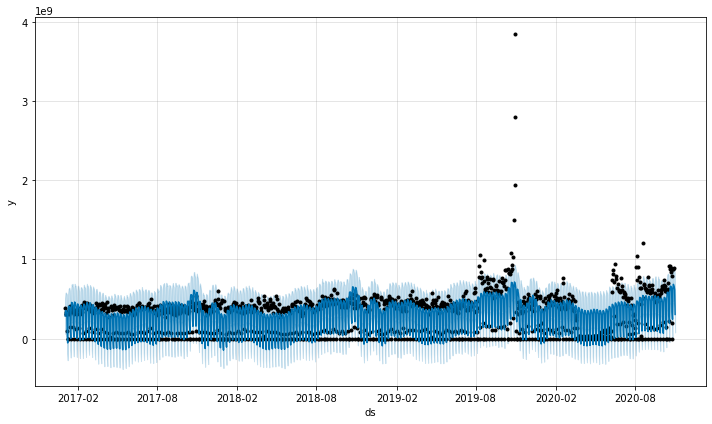

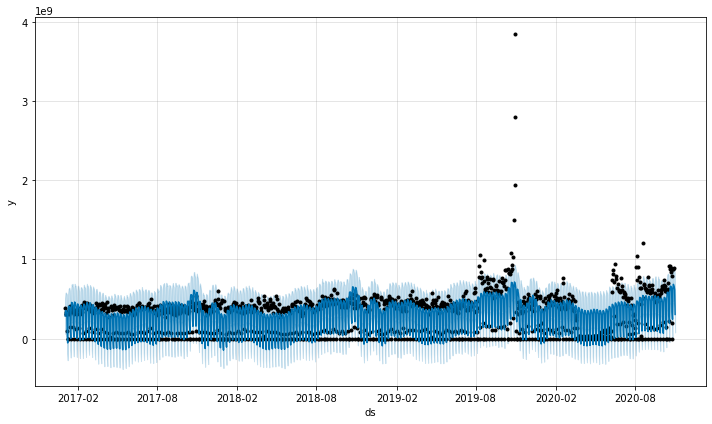

In [49]:
forecast = m1.predict(future)
m1.plot(forecast)

In [50]:
#forecast['yhat'].format()

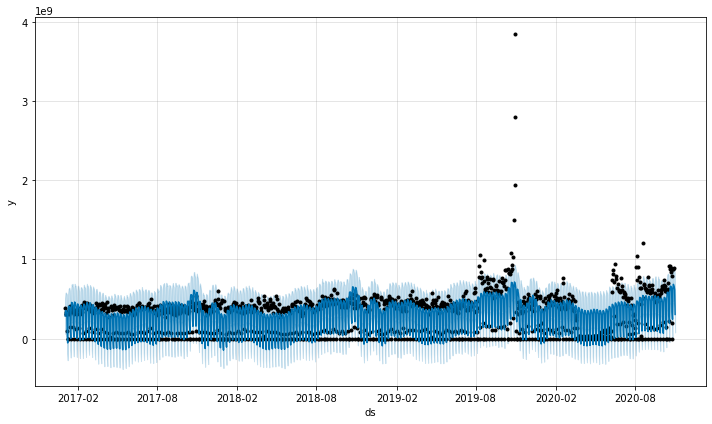

In [51]:
fig1 = m1.plot(forecast)

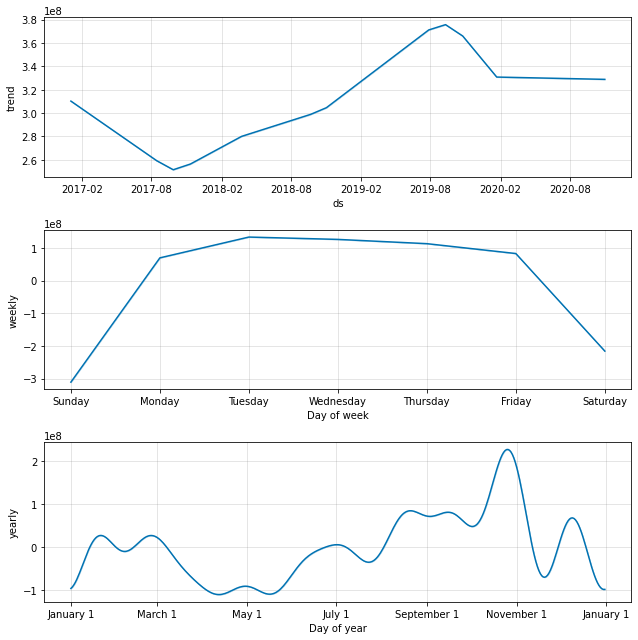

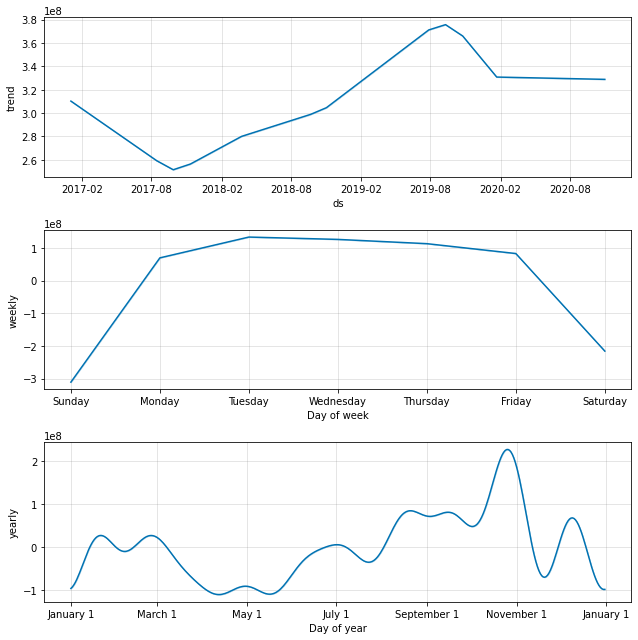

In [52]:
m1.plot_components(forecast)

In [2]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m1, forecast)

ModuleNotFoundError: No module named 'fbprophet'

In [54]:
R_daily_.tail(10)

,ds,y
1386,2020-10-19,878011485.0
1387,2020-10-20,915106213.0
1388,2020-10-21,886870047.0
1389,2020-10-22,842077803.0
1390,2020-10-23,793408349.0
1391,2020-10-24,195065947.0
1392,2020-10-25,0.0
1393,2020-10-26,884196230.0
1394,2020-10-27,878526222.0
1395,2020-10-28,896843820.0


In [85]:
### Ahora se va a normalizar la serie usando logaritmos para re escalar la serie un proceos smuy necesario

In [55]:
R_daily_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1396 entries, 0 to 1395
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1396 non-null   datetime64[ns]
 1   y       1396 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 21.9 KB


In [87]:
R_daily['y']=R_daily['y'].replace(0,0.00001)

In [88]:
R_daily['y']=np.log(R_daily['y'])

In [56]:
m = Prophet()

In [57]:
m.fit(R_daily_)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [58]:
future=m.make_future_dataframe(periods=3, include_history=True)
future.tail()

,ds
1394,2020-10-27
1395,2020-10-28
1396,2020-10-29
1397,2020-10-30
1398,2020-10-31


In [59]:
forecast=m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1394,2020-10-27,6.863831e+08,4.460038e+08,9.268790e+08
1395,2020-10-28,6.746956e+08,4.311353e+08,9.108715e+08
1396,2020-10-29,6.549818e+08,4.370990e+08,8.858199e+08
1397,2020-10-30,6.160174e+08,4.006747e+08,8.579784e+08
1398,2020-10-31,3.063235e+08,6.486548e+07,5.304414e+08


In [60]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)

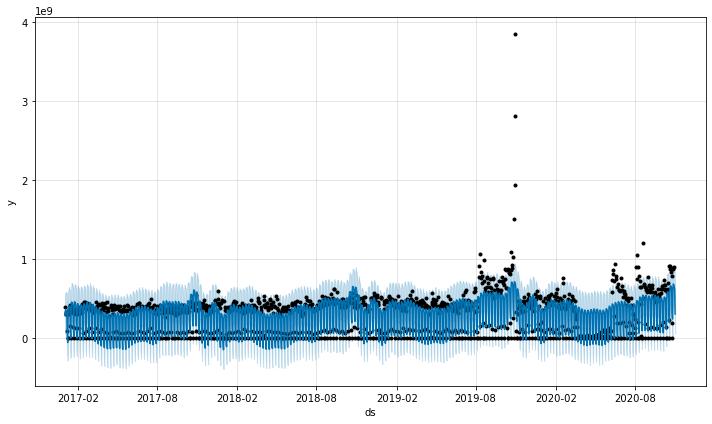

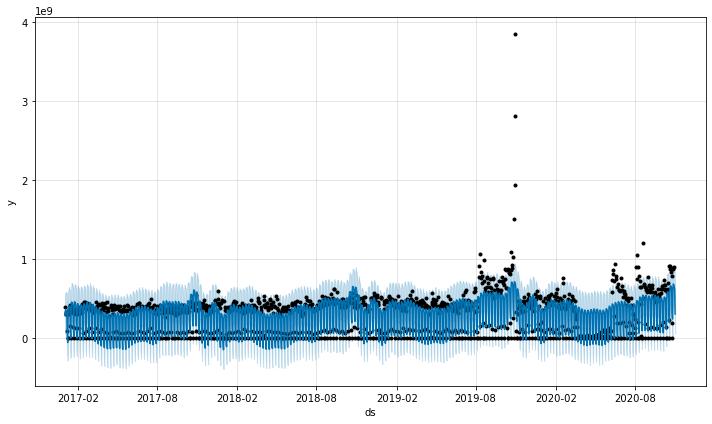

In [61]:
m.plot(forecast)

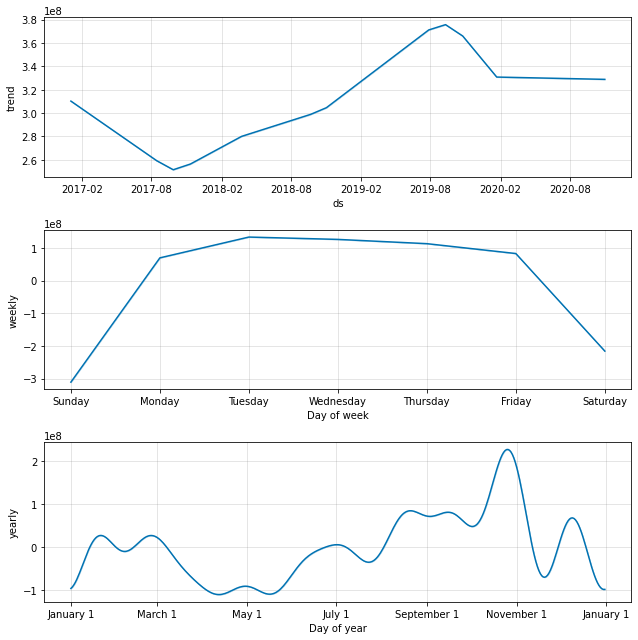

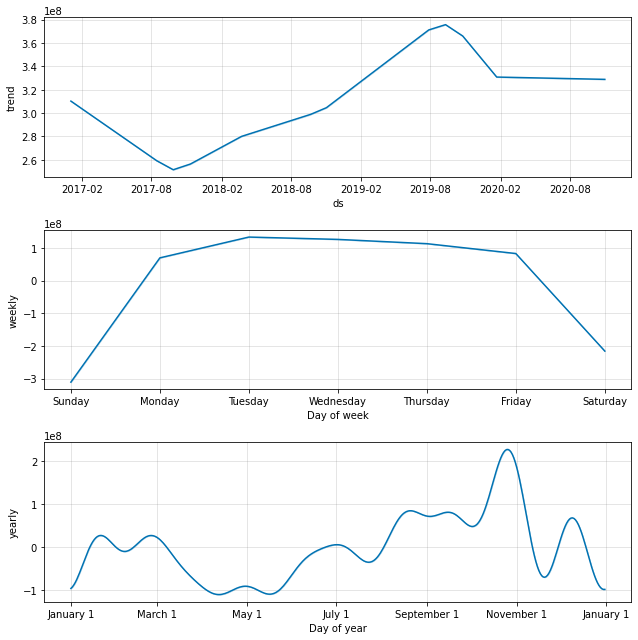

In [62]:
m.plot_components(forecast)

In [ ]:
### Add holidays

In [138]:
# Python
Fest = pd.DataFrame({
  'holiday': 'Festivos',
  'ds': pd.to_datetime(['2020-01-01', '2020-06-01', '2020-03-23',
                        '2020-04-09', '2020-04-10', '2020-05-01',
                        '2020-05-25', '2020-06-15', '2020-06-22',
                        '2020-06-29', '2020-07-20', '2020-08-07',
                        '2020-08-17', '2020-10-12','2020-11-02',
                       '2020-11-16','2020-12-08','2020-12-25']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = Fest

In [140]:
m = Prophet(holidays=holidays)
forecast = m.fit(R_daily).predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [142]:
forecast[(forecast['holidays']).abs() > 0][
        ['ds', 'holidays']][-10:]

,ds,holidays
1274,2020-06-29,-3.966450e+08
1275,2020-06-30,1.791667e+07
1295,2020-07-20,-3.966450e+08
1296,2020-07-21,1.791667e+07
1313,2020-08-07,-3.966450e+08
1314,2020-08-08,1.791667e+07
1323,2020-08-17,-3.966450e+08
1324,2020-08-18,1.791667e+07
1379,2020-10-12,-3.966450e+08
1380,2020-10-13,1.791667e+07


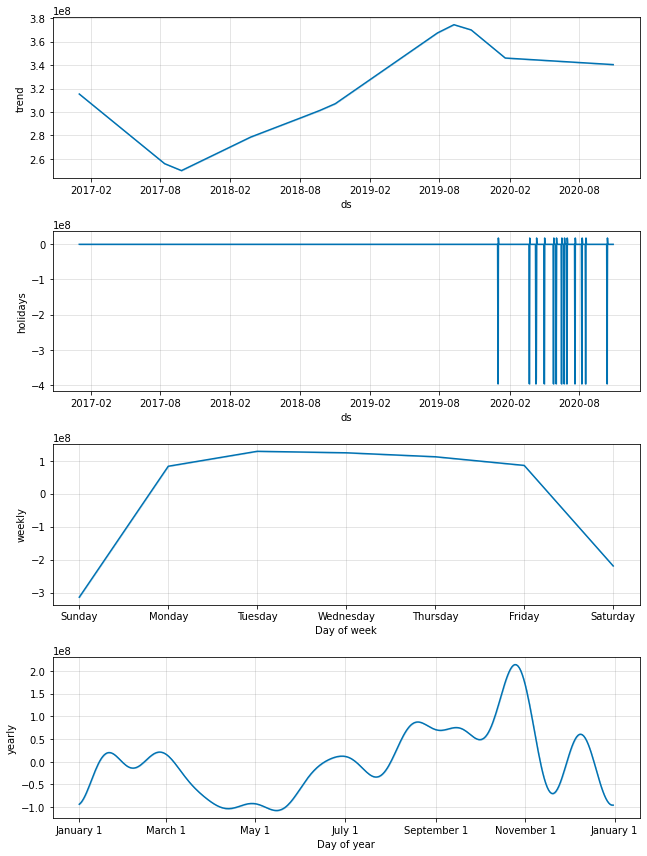

In [143]:
fig = m.plot_components(forecast)


In [145]:
m.train_holiday_names

0    Festivos
dtype: object

In [63]:
# evaluate prophet time series forecasting model on hold out dataset
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
# load data
# create test dataset, remove last 12 days
train = R_daily.drop(R_daily.index[-1:])
print(train.tail())
# define the model
model = Prophet()
# fit the model
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds            y
1391 2020-10-24  195065947.0
1392 2020-10-25          0.0
1393 2020-10-26  884196230.0
1394 2020-10-27  878526222.0
1395 2020-10-28  896843820.0


In [72]:
future = list()
for i in range(1, 26):
    date = '2020-10-%d' % i
    future.append([date])
future = pd.DataFrame(future)
future

,0
0,2020-10-1
1,2020-10-2


In [71]:
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# calculate MAE between expected and predicted values for december
y_true = R_daily['y'][-2:].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

ValueError: Found input variables with inconsistent numbers of samples: [2, 1]

In [ ]:
r_dia_dia=(rs.set_index('FECHA_PAGO').resample('D')["VALOR_TARIFA"].sum()).to_frame()
r_dia_dia=r_dia_dia.reset_index()

In [ ]:
df2 = r_dia_dia.rename(columns={'FECHA_PAGO': 'ds','VALOR_TARIFA': 'y'})
df2.tail(5)

In [ ]:
m2 = Prophet()
m2.fit(df2)
future = m2.make_future_dataframe(periods=-20)

In [ ]:
forecastday = m2.predict(future)
m2.plot(forecastday)

In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m2, forecastday)

In [ ]:
print(forecastday.tail(25))

In [ ]:
r_dia_dia=(rs.set_index('FECHA_PAGO').resample('D')["VALOR_TARIFA"].sum()).to_frame()
r_dia_dia=r_dia_dia.reset_index()

In [ ]:
r_dia_dia.tail()

In [ ]:
R_daily=rs.groupby([pd.Grouper(key='FECHA_PAGO',freq='d')]).agg({'VALOR_TARIFA':'sum'})

In [ ]:
R_daily.tail(10)

In [ ]:
### para graficar los cambios porcentuales diarios o mensuales

In [ ]:
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value  - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

# Apply your custom function and plot
prices_perc = prices.rolling(20).aggregate(percent_change)
prices_perc.loc["2019":"2020"].plot()
plt.show()

In [ ]:
r_2020

In [ ]:
r_2020.info()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.8, shuffle=False, random_state=1)

# Fit our model and generate predictions
model = Ridge()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = r2_score(y_test, predictions)
print(score)

In [ ]:
r_2020['FECHA_REGISTRA']

In [ ]:
r_2020=rs.groupby([pd.Grouper(key='FECHA_REGISTRA',freq='D')]).agg({'VALOR_TARIFA':'sum'})

## Perfil de la persona que paga

In [ ]:
rp = pd.read_csv(os.path.join('Z:\Z_Analitica\Recaudo\Recaudo_X_Infractor.csv'),sep = ";",
encoding="ISO-8859-1",parse_dates=["FECHA_LIQUIDA","FECHA_COMPARENDO","FECHA_NACIMIENTO","FECHA_NOTIFICACION"],date_parser=lambda x: pd.to_datetime(x,format ="%d/%m/%Y %H:%M:%S",errors = "coerce"))

In [ ]:
rp.columns

In [ ]:
rp.drop_duplicates(subset = "NRO_COMPARENDO",inplace = True)

In [ ]:
rp.shape

In [ ]:
## Sólo abarca el 2020

In [ ]:
rp['FECHA_LIQUIDA'].min()

In [ ]:
rp["DIAS_DESDE_NOTIFICACION"] = (dt.datetime.now() - rp["FECHA_NOTIFICACION"]).dt.days

In [ ]:
rs.columns

In [ ]:
rp.columns

In [ ]:
vu = list(set(rp.columns) - set(rs.columns))
vu

In [ ]:
len(rp.columns)

In [ ]:
ru = pd.merge(rs,rp[vu],left_on="NRO_COMPARENDO_O_MOROSO",right_on="NRO_COMPARENDO",how="left")

In [ ]:
ru.head()

In [ ]:
ru.info()

In [ ]:
ru["DESCRIPCION_TIPO_PAGO"] =np.where(ru["DESCRIPCION"].str.contains("Mov|PSE",regex = True,na = False),"Movilidad en Línea","presencial")

In [ ]:
ru["DESCRIPCION"].unique()

In [ ]:
tipo_pago = ru.groupby(["DESCRIPCION_TIPO_PAGO"]).agg({"ID_PAGA_FACTURA":"nunique","VALOR_TARIFA":"sum"})
print(tipo_pago.sort_values('VALOR_TARIFA'))

In [ ]:
por_concepto = ru.groupby(["DESCRIPCION_TIPO_PAGO","DESC_CONCEPTO"]).agg({"ID_PAGA_FACTURA":"nunique","VALOR_TARIFA":"sum"})
print(por_concepto.head())

In [ ]:
# Añadir una columna 
recaudo_2020['mes']=recaudo_2020['FECHA_PAGO'].dt.month

In [ ]:
# Obtener el total de recaudo mensual historico desde 2027
recaudo1 = recaudo_2020.groupby('mes')['VALOR_TARIFA'].sum()

# Grafico de lineas
recaudo1.plot(x='FECHA_PAGO',y='VALOR_TARIFA', kind='line')

# Show the plot
plt.show()

In [ ]:
recaudo_1 = recaudo_2020.groupby(pd.Grouper(key='FECHA_PAGO', freq='1M')).sum() # groupby each 1 month
recaudo_1.index = recaudo_1.index.strftime('%B')
print(recaudo_1.index)

In [ ]:
recaudo_1.plot(kind='line',y='VALOR_TARIFA')

In [ ]:
re=recaudo1.groupby(pd.Grouper(key='FECHA_PAGO', freq='M'))['VALOR_TARIFA'].sum()
# Grafico de lineas
re.plot(x='re',y='VALOR_TARIFA', kind='line')
# Show the plot
plt.show()

In [ ]:
recaudo_2020= pd.read_csv('Z:\\2300 - Reportes\Z_Analitica\\01_Recaudo\Recaudo_General\Recaudo_General.csv',sep = ";",
                        encoding="ISO-8859-1",parse_dates=["FECHA_PAGO"],date_parser=lambda x: pd.to_datetime(x,format ="%d/%m/%Y %H:%M:%S",errors = "coerce"))

In [ ]:
1+1

In [ ]:
recaudo_2020.columns

In [ ]:
recaudo_2020.info()

In [ ]:
cad.drop_duplicates(subset='NRO_COMPARENDO',inplace=True)
recaudo_2020.drop_duplicates(subset='NRO_COMPARENDO_O_MOROSO',inplace=True)

In [ ]:
union = pd.merge(cad, recaudo_2020,
                              left_on = "NRO_COMPARENDO",
                              right_on = "NRO_COMPARENDO_O_MOROSO",
                              how = "inner")

In [ ]:
union.shape

In [ ]:
union.head()

In [17]:
from tkinter import filedialog

In [24]:
path=filedialog.askdirectory()

In [ ]:
#writer = pd.ExcelWriter(filedialog.askdirectory() + "/fecha.xlsx",engine='xlsxwriter')

In [25]:
rs3.to_csv(path, 'data.csv',index=False)

PermissionError: [Errno 13] Permission denied: 'D:/Desktop/ITS_/Tareas/Tareas diarias/7 de noviembre'

In [ ]:
#union2.to_excel(writer,sheet_name="pago_2",index=True)

In [ ]:
writer.save()